# COGS 108 FINAL PROJECT
## Data Science and eSports: Exploratory Data Visualization on Competitive League of Legends

Name: Jun Lee, Jin Woong Yu, Victor Wong, Alfredo Lucas, Jaewon Song
PID: A09657288, A12371029, A11309796, A14251252, A91093864

One of the main reasons why the NBA and MLB in America have entertaining sport casting, discussions, and comparisons (amongst teams, players, regions) is due to the amount of significant statistics and analyses available. Questions like, “why do the GSW have such a great win record”, “who is expected to win the 2017 playoffs”, and “what can the Padres do to improve their lineup” can be addressed through data and analytics, and fans love to discuss these findings. Gathering and delivering data is an integral part of sports entertainment, and is recently being developed in the E-sports field. As the primary E-sports game, League of Legends uses data gathering and analysis regarding the E-sport during tournament play, but does not offer much insight into the game to the public.

Our team’s goal is to provide to the public interesting data and analytics about League of Legends, and to inform old and new players the multiple, interesting facets of the rising E-sports game. Specifically, using data science knowledge from our Cogs108 class, we figure out what contributes to the win rate of League of Legends (win conditions, professional tournament play statistics, and external factors, such as regions, environments, level of technology when answering this question). 


In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import lxml
import seaborn as sns
import ast
from matplotlib import pyplot
import statsmodels.api as sm
import patsy
import re
%matplotlib inline

#### We extract and clean data regarding League of Legend's tournament statistics, and each region's team gold (one of the primary game indicators to measure the team's advantage). Then, we compare the advantages each team had in relation to the other team's, and visualize our findings. A more detailed analysis is given under the data tables and visualizations, and the extraction process is commented. 

In [2]:
# Created a soup object (using BS4 library) to store the table 
team_rate = requests.get("http://league-analytics.com/2016-worlds-team-stats/")
a = team_rate.content

team_soup = BeautifulSoup(a,"html.parser")
team_table = team_soup.find("table", {"id" : "table_1"})

# Created 2 data arrays to store the headers and row data
team_data = []
team_header_row = []

# Found the tags in the website that contains our data
team_table_body = team_table.find('tbody')
team_header = team_table.find_all('th')
team_rows = team_table_body.find_all('tr')

# Extracted data from website and placed into our own "table"
for hd in team_header:
    team_header_row.append(hd.text)
    
for row in team_rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    team_data.append([ele for ele in cols if ele]) # Get rid of empty values

### International Tournament Play data

In [3]:
# Stored our data in a panda dataframe
team_df = pd.DataFrame(team_data, columns = team_header_row)
team_df

,Team,team_region,Games Played,Win Percentage (%),Average Game Time,First Blood Participation (%),First Tower Participation (%),First Dragon Participation (%),First Baron Participation (%),Team,...,Absolute Gold Difference @15,Team,DGS (ADC) / DGS (Mid),Share of Overall Jungle Monsters Killed (%),Wards per Minute,Wards Cleared per Minute,GSE: Gold Shift Events (count),GSE won (%),GSE won when significantly ahead 2 min. before (%),GSE won when significantly behind 2 min. before (%)
0,AHQ,empty,6,50.00,40.09,66.67,50.00,83.33,83.33,AHQ,...,"2,091.33",AHQ,0.88,54.41,3.88,1.46,24,62.50,77.78,100.00
1,ANX,Wildcard,10,40.00,36.36,60.00,40.00,60.00,50.00,ANX,...,"2,967.40",ANX,0.66,44.02,3.14,1.19,52,28.85,71.43,0
2,C9,NA,9,33.33,43.28,44.44,44.44,55.56,22.22,C9,...,"1,770.78",C9,1.25,48.47,3.36,1.51,38,36.84,90.00,0
3,CLG,NA,6,50.00,35.80,33.33,50.00,50.00,50.00,CLG,...,"1,697.17",CLG,1.02,54.05,3.26,1.39,30,60.00,90.00,0
4,EDG,LPL,11,45.45,38.35,36.36,36.36,27.27,36.36,EDG,...,"2,642.27",EDG,1.25,49.90,3.64,1.52,57,35.09,87.50,10.34
5,FW,LMS,6,33.33,46.68,50.00,83.33,33.33,66.67,FW,...,"1,539.50",FW,0.76,47.11,3.99,1.64,23,43.48,100.00,0
6,G2,EU,6,16.67,37.78,50.00,33.33,33.33,16.67,G2,...,"1,780.67",G2,1.14,48.25,3.57,1.21,29,37.93,71.43,14.29
7,H2K,EU,13,61.54,36.18,76.92,69.23,53.85,46.15,H2K,...,"3,145.69",H2K,1.07,49.41,3.85,1.51,66,60.61,85.19,7.69
8,IM,LPL,6,33.33,42.59,33.33,0,33.33,50.00,IM,...,"3,220.67",IM,0.98,45.68,3.62,1.67,30,26.67,100.00,5.26
9,ITZ,empty,6,16.67,33.42,0,50.00,0,16.67,ITZ,...,"2,804.00",ITZ,0.94,45.12,3.55,1.18,28,32.14,100.00,18.18


[DATA CLEANED] COLUMN ADDED FROM ORIGINAL CHART:

team_region | First Baron Participation (%) | Team | Dragon Rate (%) | ss2 | gpmg | gpm | dpm_diff_avg |  GSE won when significantly ahead 2 min. before (%), GSE won when significantly behind 2 min. before (%)

To begin diving into the hypothesis, we will explore the statistics of gold to measure the performance of teams in the 2016 World Championships of League of Legends (note: the 2017 World Championship is set to begin in the fall). SPOILERS: The winner of the tournament was a Korean team by the name of SKT, and teams from the Korean region, LCK, are regarded as the ones that have mastered the game to the fullest. The following blocks of code will further clean and process the data and plot the results, so we can do some visual data exploration and hopefully quantify some phenomena.

In [4]:
team_df.columns

Index(['Team', 'team_region', 'Games Played', 'Win Percentage (%)',
       'Average Game Time', 'First Blood Participation (%)',
       'First Tower Participation (%)', 'First Dragon Participation (%)',
       'First Baron Participation (%)', 'Team', 'Dragon Rate (%)', 'ss1',
       'ss2', 'gpmg', 'gpm', 'dpm_diff_avg', 'gpm_diff_avg', 'Team',
       'First Mid Tower Rate', 'Ahead: Time with at least 52% of  gold (%)',
       'Behind: Time with 48% or less of gold (%)', 'Gold Difference @15',
       'Absolute Gold Difference @15', 'Team', 'DGS (ADC) / DGS (Mid)',
       'Share of Overall Jungle Monsters Killed (%)', 'Wards per Minute',
       'Wards Cleared per Minute', 'GSE: Gold Shift Events (count)',
       'GSE won (%)', 'GSE won when significantly ahead 2 min. before (%)',
       'GSE won when significantly behind 2 min. before (%)'],
      dtype='object')

### Gold Difference between Teams

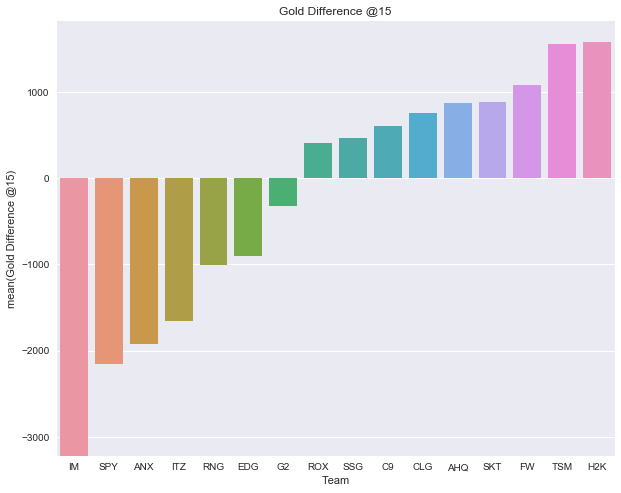

In [5]:
# Used our dataframe object to categorize our data, and find the range of gold differences
attr = ['Team','Gold Difference @15','GSE: Gold Shift Events (count)','Absolute Gold Difference @15','team_region',
     'GSE won (%)', 'GSE won when significantly ahead 2 min. before (%)', 'GSE won when significantly behind 2 min. before (%)',
       'Games Played']
gold_ebb_flow = team_df[attr]
gold_ebb_flow.columns = range(len(gold_ebb_flow.columns))
gold_ebb_flow = gold_ebb_flow.drop(gold_ebb_flow.columns[[0,1,2]],axis=1)
gold_ebb_flow.columns = attr

# Compared the gold differences among the different teams
for head in ['Gold Difference @15','GSE: Gold Shift Events (count)','GSE won (%)','GSE won when significantly ahead 2 min. before (%)', 'GSE won when significantly behind 2 min. before (%)', 'Games Played']:
    for i in range(len(gold_ebb_flow[head])):
        if gold_ebb_flow[head][i].find(',') == -1:
            gold_ebb_flow[head][i] = ast.literal_eval(gold_ebb_flow[head][i])
        else:
            gold_ebb_flow[head][i] = gold_ebb_flow[head][i].replace(',','')
            gold_ebb_flow[head][i] = ast.literal_eval(gold_ebb_flow[head][i]) ## Cleaning the string-like numerical entries

# Sorted the gold difference values  
gd15_dat = gold_ebb_flow.sort_values("Gold Difference @15")

#Plotted and visualized the gold differences by teams
pyplot.subplots(figsize=(10,8))       
ax = sns.barplot(x="Team", y="Gold Difference @15", data=gd15_dat)
ax.set(title = 'Gold Difference @15')

The graph above shows the average amount of gold a team will have over or under their opponent at 15 minutes into the game. In League of Legends, the amount of gold accrued by a team is an indicator of an advantage that team holds over the other team. Gold can be exchanged in game to purchase weapons, armor, and other items that can enhance a players' character. In game gold can also be used to measure how well a team is controlling the game since gold is awarded in game for accomplishing objectives such as eliminating opposing players, destroying their buildings, consuming their resources, and securing contested neutral points on the map.

The difference in gold between teams at the 15 minute mark indicates how well or poorly a team is able to play out the early portion of the game. A typical game of League of Legends lasts about 25 to 35 minutes, ending when one team's base is destroyed by their opponents or a surrender. The 15 minute mark is a halfway point that can dictate how well a team can control the outcome of the game. It should be simple, right? Theoretically, if a team has good control of the game at 15 minutes, they should essentially control the outcome of the game; however, we know the results of the tournament, which makes this graph misleading because the LCK Teams: ROX, SKT, and SSG are said to be the best teams in the tournament by the analysts.

Let's zoom in on this graph and look at only Korea (LCK) and North America.

Mean Korean gold difference at 15 minutes is 582.6533333333333
Mean North American gold difference at 15 minutes is 971.3166666666666
Mean number of games played by Korean teams: 17.666666666666668
Mean number of games played by North American teams: 7.0


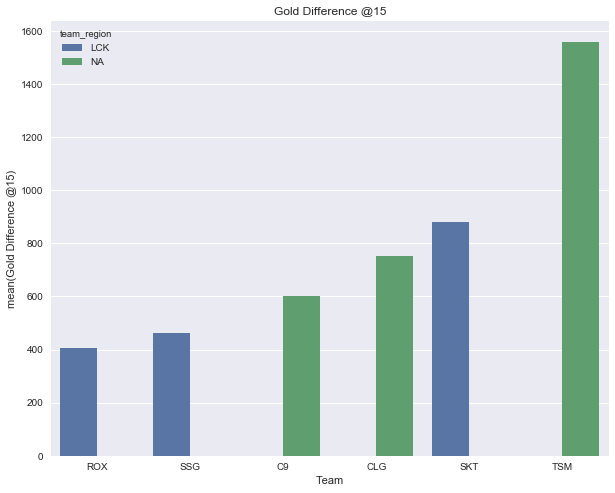

In [6]:
# Used Korea and North America region column data to limit our comparison
gd15_kr_vs_NA = gd15_dat.loc[(gd15_dat['team_region']=='LCK')|(gd15_dat['team_region']=='NA')]

# Plotted a visualization looking at the gold difference between the 2 regions
pyplot.subplots(figsize=(10,8))       
ax = sns.barplot(x="Team", y="Gold Difference @15", data=gd15_kr_vs_NA, hue = 'team_region')
ax.set(title = 'Gold Difference @15')
print("Mean Korean gold difference at 15 minutes is {}".format(gd15_kr_vs_NA[gd15_kr_vs_NA['team_region']=='LCK']['Gold Difference @15'].mean()))
print("Mean North American gold difference at 15 minutes is {}".format(gd15_kr_vs_NA[gd15_kr_vs_NA['team_region']=='NA']['Gold Difference @15'].mean()))
print("Mean number of games played by Korean teams: {}".format(gd15_kr_vs_NA[gd15_kr_vs_NA['team_region']=='LCK']['Games Played'].mean()))
print("Mean number of games played by North American teams: {}".format(gd15_kr_vs_NA[gd15_kr_vs_NA['team_region']=='NA']['Games Played'].mean()))

Looking at this, it is surprising to see that North American teams had a larger gold lead at fifteen minutes on average than Korean teams (KR:NA = 582.7g:971g). However, upon further inspection, the observed numbers can be easily explained. For one, the tournament was set up in a bracket system with elimination, so less skilled teams would be eliminated early on, and more skilled teams would have to play more games against progressively more skilled opponents. Since Korean teams on average had to play 10 more games than North American teams in addition to the games becoming progressively harder, it makes sense that Korean teams aren't able to as readily accrue gold leads early on against their opponents in game, which results in the numbers looking either unexpectedly large or small.

So This leads us to believe that the amount of gold a team has accrued at the 15 minute mark in a game isn't going to be fully indicative of a team's ability to control a game. However, there are other ways to examine the flux in gold such as a Gold Shift Event (GSE). A Gold Shift Event is an instance in game where a large influx of gold is accrued by a team in a short period of time (More on this metric: http://league-analytics.com/2016/06/15/gold-shift-events-happenings-on-summoners-rift/). A GSE is qualitatively, an event that occurs in game where one team makes a move on the other, the exciting part of the game where players' characters die, buildings are breached,or territory is claimed. GSE's can be leveraged to gain insight on their in game behavior.

### Gold Shift Events (large gold changes) by Team

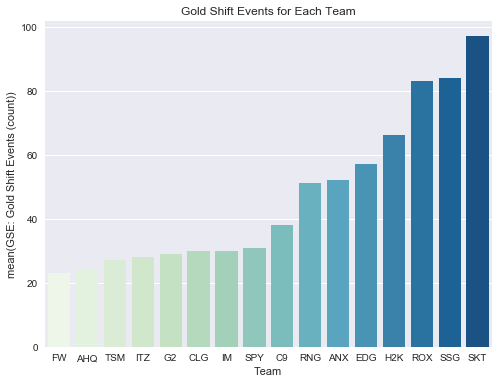

In [7]:
# Sorted and plotted the gold shift events
gse_dat = gold_ebb_flow.sort_values('GSE: Gold Shift Events (count)')
pyplot.subplots(figsize=(8,6))       
ax2 = sns.barplot(x="Team", y="GSE: Gold Shift Events (count)", data=gse_dat,palette="GnBu")
ax2.set(title = 'Gold Shift Events for Each Team')

Mean number of gold shift events experienced by Korean teams: 88.0
Mean number of gold shift events experienced by North American teams: 31.666666666666668


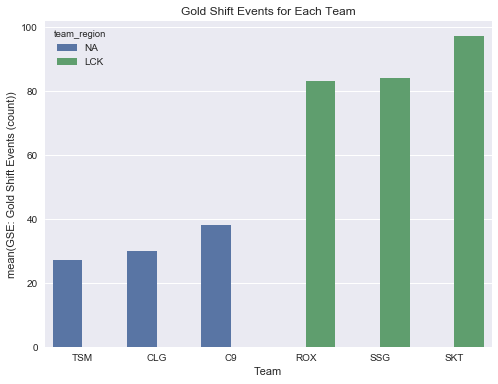

In [8]:
# Sorted and plotted Korea and North America teams' gold shift events
pyplot.subplots(figsize=(8,6))       
ax2 = sns.barplot(x="Team", y="GSE: Gold Shift Events (count)", data=gse_dat.loc[(gd15_dat['team_region']=='LCK')|(gd15_dat['team_region']=='NA')],hue='team_region')
ax2.set(title = 'Gold Shift Events for Each Team')
print("Mean number of gold shift events experienced by Korean teams: {}".format(gse_dat[gse_dat['team_region']=='LCK']['GSE: Gold Shift Events (count)'].mean()))
print("Mean number of gold shift events experienced by North American teams: {}".format(gse_dat[gse_dat['team_region']=='NA']['GSE: Gold Shift Events (count)'].mean()))

From here one can see that on average, Korean teams experience more gold shift events. This shows in the methodically aggressive play observed in Korean teams. Korean teams typically use extreme calculated aggression at specific time points in the game to accrue gold leads instead of waiting for opponents to make mistakes. This risk taking and high pressure play style reflects itself in these GSE's, where there are many points in the game where Korean teams gain advantages over their opponents.

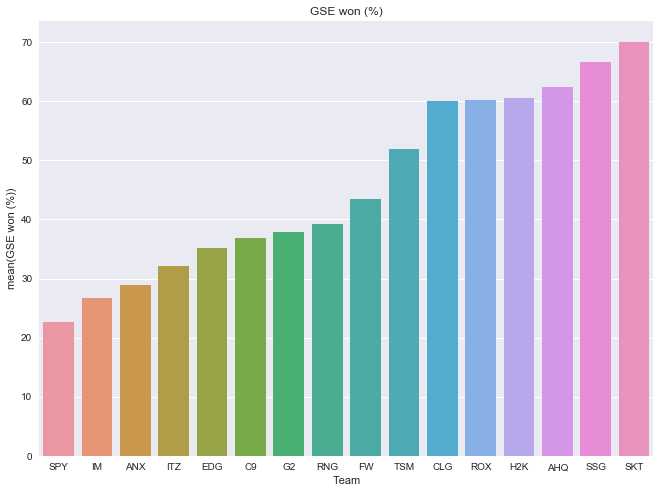

In [9]:
# Plotted the win rates in comparison the gold shift events
gs_won_dat = gold_ebb_flow.sort_values("GSE won (%)")
pyplot.subplots(figsize=(11,8))       
ax3 = sns.barplot(x="Team", y="GSE won (%)", data=gs_won_dat)# hue = 'team_region')
ax3.set(title = 'GSE won (%)')

# SPOILERS
It comes as no surprise that the top two teams in the tournament overall, SSG and SKT, had the highest win rate when it came to GSEs. This quantitatively shows that the best teams in the world are ones that take risks and make active moves against their opponents and punish them. No wonder so many fans were raving about how exciting the final 5 game series between SSG and SKT was.

### Ranked/Ordered Network latency by Region

For competitive gaming, internet connection is one of the primary tools in assessing and improving players' gameplay. By practicing the E-Sport via a fluid internet connection, players can improve their gameplay reaction time, strategize future events quicker, and prepare for in-game micro-mechanics at a higher level. Essentially, the faster the internet connection, the more connected players become to the game (understanding the environment, small features/details, potential micro-factors). We extracted data regarding network ping and latency, and ranked the data in an ordered fashion to see which region's internet came out top.

In [10]:
# Extracted network data from source, stored in a bs4 object
network_page = requests.get('https://www.fastmetrics.com/internet-connection-speed-by-country.php')
network_object = BeautifulSoup(network_page.content, 'html.parser')

# Located table tag, stored/converted data into tabular row, columns
network_table = network_object.find("table", {"class":"states countries"})
network_data = []
network_header_row = []
network_table_body = network_table.find('tbody')
network_table_header = network_table.find('thead')
network_header = network_table_header.find_all('th')
network_rows = network_table_body.find_all('tr')

for hd in network_header:
    network_header_row.append(hd.text)
    
for row in network_rows:
    cols = row.find_all('td')
    cols_head = row.find('th')
    cols = [ele.text.strip() for ele in cols]
    cols.insert(0,re.sub('<[^>]*>', '', cols_head.text))
    network_data.append([ele for ele in cols if ele]) # Get rid of empty values

# Stored table data into a panda dataframe    
network_df = pd.DataFrame(network_data, columns = network_header_row)
network_df

,Country,Q4 2015 Avg. Mbps,% Above 4 Mbps,% Above 10 Mbps,% Above 15 Mbps
0,Global Average,5.6,-,-,-
1,South Korea,26.7,96.7%,80.5%,62.6%
2,Sweden,19.1,93%,59.5%,42.4%
3,Norway,18.8,89.8%,61.8%,44.7%
4,Japan,17.4,91.1%,62.8%,40.3%
5,Netherlands,17.0,95.7%,64.5%,38.8%
6,Hong Kong,16.8,93.2%,61.1%,37.8%
7,Switzerland,16.7,93.6%,62.1%,37.5%
8,Latvia,16.7,92.5%,54.1%,37%
9,Finland,16.6,91%,57.4%,34.4%


In [11]:
# Same steps as the previous table, but extracted North America specific data
network_page_america = requests.get('https://www.fastmetrics.com/internet-connection-speed-by-country.php')
network_object_america = BeautifulSoup(network_page_america.content, 'html.parser')
network_table_america = network_object_america.find("div", {"id":"top-10-america"})

network_data_america = []
network_header_row_america = []
network_table_body_america = network_table_america.find('tbody')
network_table_header_america = network_table_america.find('thead')
network_header_america = network_table_header_america.find_all('th')
network_rows_america = network_table_body_america.find_all('tr')

for hd in network_header_america:
    network_header_row_america.append(hd.text)
    
for row in network_rows_america:
    cols = row.find_all('td')
    cols_head = row.find('th')
    cols = [ele.text.strip() for ele in cols]
    cols.insert(0,re.sub('<[^>]*>', '', cols_head.text))
    network_data_america.append([ele for ele in cols if ele]) # Get rid of empty values

network_df_america = pd.DataFrame(network_data_america, columns = network_header_row_america)
network_df_america

,Country,Q4 2015 Avg. Mbps,% Above 4 Mbps,% Above 10 Mbps,% Above 15 Mbps
0,United States,14.2,82.8%,52.9%,31.6%
1,Canada,13.1,88.2%,48.8%,27%
2,Uruguay,6.2,71.7%,8.8%,2%
3,Chile,6.1,67.3%,10.1%,2.8%
4,Mexico,5.9,67.9%,8.2%,2.2%
5,Argentina,4.7,46.2%,4.4%,0.7%
6,Peru,4.5,47.1%,2.9%,0.9%
7,Colombia,4.5,50.6%,2.2%,0.5%
8,Ecuador,4.4,41.8%,3.3%,0.8%
9,Brazil,4.1,39%,2.9%,0.8%


### Champions (In-Game character options) choices and performances

Quite possibly the most fluctuating element of the game, Champions (or in-game character options) determine how each team plays the game to win. They can be thought of as roster changes, and the strategy to win the game changes depending on your roster. Thus, we extracted a large amount of data on Champions, to determine what are currently the most used Champions, which Champions are dominant in professional play, and which Champions do regions prefer to use. 

After extracting online data from various sources (including Riot's own API), we visualize the data through joined scatter plots. 

In [12]:
## 2016 World Championship Pick/Ban Statistics (Overall) ##
stats_16  = requests.get("http://lol.gamepedia.com/2016_World_Championship/Champion_Statistics")
b = stats_16.content

# Extracted data according to source styling
stats_soup = BeautifulSoup(b,"html.parser")
stats_table = stats_soup.find("table", {"style" : "width:100%;margin-left:auto; margin-right:auto; margin-bottom:-1px; margin-top:0px"})

# Created the header and row data arrays
stats_data = []
stats_header_row = []

#stats_table_body = stats_table.find('tbody')
stats_header = stats_table.find_all('th')
stats_rows = stats_table.find_all('tr')

for hd in stats_header:
    stats_header_row.append(hd.text)
    
for row in stats_rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    stats_data.append([ele for ele in cols if ele]) # Get rid of empty values

# Placed data values into a panda dataframe
stats_df = pd.DataFrame(stats_data, columns = stats_header_row)
stats_df = stats_df.drop([0])
stats_df


,Champion,Bans,Picks,Wins,Losses,Win %,Picked/Banned in % of Games,Champ Kills,Champ Deaths,Champ Assists,Champ KDA
1,Nidalee,66,11,8,3,72.7,100,28,31,60,2.84
2,Syndra,59,16,10,6,62.5,97.4,77,40,70,3.68
3,Olaf,23,36,18,18,50,76.6,90,82,205,3.6
4,Karma,16,42,19,23,45.2,75.3,24,106,289,2.95
5,Elise,21,29,10,19,34.5,64.9,64,75,143,2.76
6,Jhin,12,38,23,15,60.5,64.9,146,73,224,5.07
7,Caitlyn,15,34,16,18,47.1,63.6,93,74,143,3.19
8,Jayce,21,26,15,11,57.7,61,71,74,138,2.82
9,Ryze,27,19,10,9,52.6,59.7,71,34,85,4.59
10,Lee Sin,8,37,21,16,56.8,58.4,100,88,233,3.78


In [13]:
# Extracted detail data from the source site regarding champion win rate details, picked rates, in-game stats
champion_stats_16 = requests.get("http://oracleselixir.com/statistics/champions/2016-world-championships-champion-statistics/")
c = champion_stats_16.content

# Found tag and parsed into bs4 object
champion_stats_16_soup = BeautifulSoup(c,"html.parser")
champion_stats_16_table = champion_stats_16_soup.find("table", {"id" : "tablepress-243"})

# Created arrays for our table column and row data
champion_stats_16_data = []
champion_stats_16_header_row = []

# Found tags to identify where the data lies in the source
champion_stats_16_table_body = champion_stats_16_table.find('tbody')
champion_stats_16_header = champion_stats_16_table.find_all('th')
champion_stats_16_rows = champion_stats_16_table_body.find_all('tr')

for hd in champion_stats_16_header:
    champion_stats_16_header_row.append(hd.text)
    
for row in champion_stats_16_rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    champion_stats_16_data.append([ele for ele in cols if ele]) # Get rid of empty values

# Stored our data into a panda dataframe
champion_stats_16_df = pd.DataFrame(champion_stats_16_data, columns = champion_stats_16_header_row)
champion_stats_16_df

,Champion,Position,GP,P%,B%,P+B%,W%,AGT,KPG,DPG,...,CKPM,FB%,FBD%,CSD@10,GD@10,CSPM,DPM,Dmg%,EGPM,Gold%
0,Alistar,Support,23,29.9%,6.5%,36.4%,65.2%,37.8,0.6,2.6,...,0.63,39.1%,13.0%,4.4,-21.2,1.0,119,6.0%,126.2,10.9%
1,Anivia,Middle,1,1.3%,1.3%,2.6%,100.0%,40.4,2.0,2.0,...,0.37,100.0%,0.0%,13.0,708.0,7.5,560,24.9%,256.9,20.8%
2,Ashe,ADC,11,14.3%,5.2%,19.5%,63.6%,41.3,3.0,2.4,...,0.62,18.2%,9.1%,2.3,103.0,9.3,453,22.2%,294.7,24.3%
3,Aurelion Sol,Middle,12,15.6%,26.0%,41.6%,66.7%,37.7,4.9,2.5,...,0.72,41.7%,16.7%,-1.7,82.7,7.6,531,25.2%,256.2,22.0%
4,Bard,Support,12,15.6%,6.5%,22.1%,25.0%,35.0,1.0,3.9,...,0.79,16.7%,8.3%,-2.8,-76.4,0.6,189,9.9%,119.6,11.8%
5,Brand,Support,1,1.3%,10.4%,11.7%,100.0%,40.4,3.0,1.0,...,0.37,0.0%,0.0%,1.0,107.0,0.8,551,24.6%,186.5,15.1%
6,Braum,Support,16,20.8%,0.0%,20.8%,37.5%,36.6,0.6,2.4,...,0.60,12.5%,12.5%,4.8,-34.7,1.2,146,7.6%,118.3,10.7%
7,Caitlyn,ADC,34,44.2%,19.5%,63.6%,47.1%,38.5,2.7,2.2,...,0.62,17.6%,8.8%,4.0,25.8,9.3,511,26.5%,278.5,25.1%
8,Cassiopeia,Middle,22,28.6%,7.8%,36.4%,36.4%,36.0,3.0,2.7,...,0.67,18.2%,18.2%,0.0,-32.8,8.3,426,22.5%,249.6,23.1%
9,Ekko,Top,10,13.0%,1.3%,14.3%,50.0%,35.9,3.0,2.3,...,0.68,0.0%,20.0%,-12.2,-383.4,8.3,387,19.0%,256.9,22.1%


### Granular in-game data to aggregated data

We extract detailed game elements, and see the relationships between the elements when combined.
We used two primary data sources- loldata.com and lolstats.com, and both of them stored their data into JSON objects.

In [14]:
# Locate the source url
champ_url = 'http://loldata.services.zam.com/v1/champion'

# Found the defined JSON object, cleaned and formatted info retrieved
champ_headers = {'Host': 'loldata.services.zam.com',
'Connection': 'keep-alive',
'Accept': 'application/json, text/plain, */*',
'Origin': 'http://www.lolking.net',
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
'Referer': 'http://www.lolking.net/charts',
'Accept-Encoding': 'gzip, deflate, sdch',
'Accept-Language': 'en-US,en;q=0.8,ko;q=0.6'}

champ_response = requests.get(champ_url, headers=champ_headers)

# Stored the JSON object into our own list 
# We have a list of all the champions in the League of Legends game to use
champ_json = champ_response.json()
champ_list = pd.DataFrame(champ_json)
champ_list = champ_list[['champion_id','name']]

In [15]:
# Locate the source url
item_url = 'http://loldata.services.zam.com/v1/item?page=1&pageSize=10000&sort=name'

# Found the defined JSON object, cleaned and formatted info retrieved
item_headers = {'Host': 'loldata.services.zam.com',
'Connection': 'keep-alive',
'Accept': 'application/json, text/plain, */*',
'Origin': 'http://www.lolking.net',
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
'Referer': 'http://www.lolking.net/items',
'Accept-Encoding': 'gzip, deflate, sdch',
'Accept-Language': 'en-US,en;q=0.8,ko;q=0.6'}

item_response = requests.get(item_url, headers=item_headers)

# Stored the JSON object into our own list 
# We have a list of all the items in the League of Legends game to use
item_json = item_response.json()
item_list = pd.DataFrame(item_json)
item_list = item_list[['item_id','name']]

#### Using the comprehensive list of in game items available above, we match the in game item to the win rate of each item. We merge the 2 data sets (items, win rate) to create an item win rate list.

In [16]:
## Highest Winrate Items ##
item_h_win_url = 'http://lolstats.services.zam.com/v1/items/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=na&slice=weekly&sort=win_rate&start_date=2017-05-11T05:00:00.000Z'

# Extract the JSON object
item_h_win_headers = {'Host': 'lolstats.services.zam.com',
'Connection': 'keep-alive',
'Accept': 'application/json, text/plain, */*',
'Origin': 'http://www.lolking.net',
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
'Referer': 'http://www.lolking.net/charts',
'Accept-Encoding': 'gzip, deflate, sdch',
'Accept-Language': 'en-US,en;q=0.8,ko;q=0.6'}

item_h_win_response = requests.get(item_h_win_url, headers=item_h_win_headers)

# Use item list to combine with win rate
item_h_win_json = item_h_win_response.json()
item_h_win = pd.DataFrame(item_h_win_json['item_data'])
item_h_win = item_h_win.merge(item_list, how="left")
item_h_win= item_h_win[['item_id','name','map','total_games','total_wins','win_rate']]
item_h_win

,item_id,name,map,total_games,total_wins,win_rate
0,3056,Ohmwrecker,11,154,116,0.753247
1,3041,Mejai's Soulstealer,11,8836,6485,0.733929
2,3026,Guardian Angel,11,45756,29623,0.647412
3,3083,Warmog's Armor,11,3972,2542,0.639980
4,3139,Mercurial Scimitar,11,10023,6397,0.638232
5,3072,The Bloodthirster,11,10195,6432,0.630897
6,3050,Zeke's Harbinger,11,2409,1494,0.620174
7,3089,Rabadon's Deathcap,11,28821,17815,0.618126
8,3060,Banner of Command,11,1345,828,0.615613
9,3222,Mikael's Crucible,11,6941,4214,0.607117


In [17]:
## Lowest Winrate Items ##
item_l_win_url = 'http://lolstats.services.zam.com/v1/items/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=na&slice=weekly&sort=%2Bwin_rate&start_date=2017-05-11T05:00:00.000Z'

item_l_win_response = requests.get(item_l_win_url, headers=item_h_win_headers)

item_l_win_json = item_l_win_response.json()
item_l_win = pd.DataFrame(item_l_win_json['item_data'])

item_l_win = item_l_win.merge(item_list, how="left")
item_l_win = item_l_win[['item_id','name','map','total_games','total_wins','win_rate']]
#item_l_win

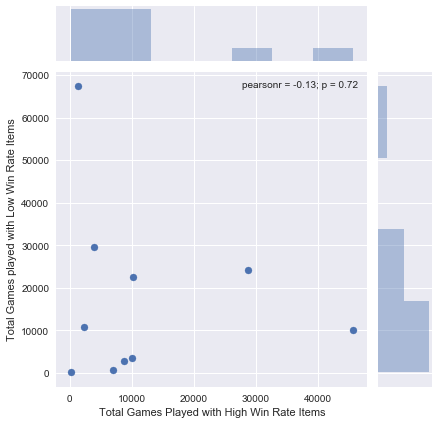

In [18]:
item_total_game = pd.DataFrame([])
item_total_game['Total Games Played with High Win Rate Items'] = item_h_win['total_games']
item_total_game['Total Games played with Low Win Rate Items'] = item_l_win['total_games']
f = sns.jointplot(x="Total Games Played with High Win Rate Items", y="Total Games played with Low Win Rate Items", data=item_total_game)

#### Using the comprehensive list of in game champions available above, we match the in game champions to the win rate of each champions. We merge the 2 data sets (champions, win rate) to create a champions win rate list.

In [19]:
## Highest Winrate Champions ##
champ_h_win_url = 'http://lolstats.services.zam.com/v1/champion/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=na&slice=weekly&sort=win_rate&start_date=2017-05-11T05:00:00.000Z'

champ_h_win_response = requests.get(champ_h_win_url, headers=item_h_win_headers)

champ_h_win_json = champ_h_win_response.json()
champ_h_win = pd.DataFrame(champ_h_win_json['champion_data'])
champ_h_win.columns = ['champion_id', 'total_games', 'total_wins', 'win_rate']
champ_h_win = champ_h_win.merge(champ_list, how="left")
champ_h_win = champ_h_win[['champion_id','name','total_games', 'total_wins', "win_rate"]]
#champ_h_win


In [20]:
## Lowest Winrate Champions ##
champ_l_win_url = 'http://lolstats.services.zam.com/v1/champion/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=na&slice=weekly&sort=%2Bwin_rate&start_date=2017-05-11T05:00:00.000Z'

champ_l_win_response = requests.get(champ_l_win_url, headers=item_h_win_headers)

champ_l_win_json = champ_l_win_response.json()
champ_l_win = pd.DataFrame(champ_l_win_json['champion_data'])
champ_l_win.columns = ['champion_id', 'total_games', 'total_wins', 'win_rate']
champ_l_win = champ_l_win.merge(champ_list, how="left")
champ_l_win = champ_l_win[['champion_id','name','total_games', 'total_wins', "win_rate"]]
#champ_l_win

It's easy to think that players of a competitive eSport would value champions for their inherit power, and their ability to win their games; however, this can be misleading. Players will typically gravitate towards champions that will appeal to them based simply on level of enjoyment. Different champions will yield different gameplay experiences, and some experiences are more enjoyable to players. High popularity champions can end up having low win rates because the average playerbase is too unskilled to control the champion properly, and low popularity champions can potentially have higher winrates due to having a smaller, more dedicated playerbase learning how to master them.

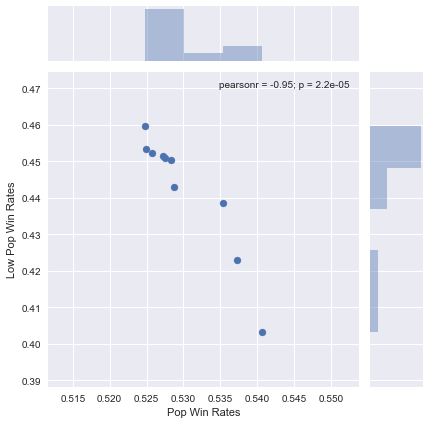

In [21]:
Champ_wr = pd.DataFrame([])
Champ_wr['Pop Win Rates'] = champ_h_win['win_rate']
Champ_wr['Low Pop Win Rates'] = champ_l_win['win_rate']
g = sns.jointplot(x="Pop Win Rates", y="Low Pop Win Rates", data=Champ_wr)
#g.set(title='Jointplot of the Win Rates of the Most Popular Champions vs. the Win Rates of the Least Popular Champions')

# Attempting to Predict Number of Wins Based on Number of Games Played with Popular Champions

Here we will attempt to make predictions using the popular champions data in an attempt to see if we can predict the number of wins obtained based on the number of games played using popular champions.

First, we extract the most popular champions through our lolstats data source, and structure the passed in JSON object by left joining our previous champion data to the new object. We compile a champion list by region, and use the new data object to retrieve the win rate of each champion.

In [22]:
## Most Popular Champions: NA ##
most_pop_champ_url_NA = 'http://lolstats.services.zam.com/v1/champion/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=na&slice=weekly&sort=total_games&start_date=2017-05-11T05:00:00.000Z'

most_pop_champ_response_NA = requests.get(most_pop_champ_url_NA, headers=item_h_win_headers)

most_pop_champ_json_NA = most_pop_champ_response_NA.json()
most_pop_champ_NA = pd.DataFrame(most_pop_champ_json_NA['champion_data'])
most_pop_champ_NA.columns = ['champion_id', 'total_games', 'total_wins', 'win_rate']
most_pop_champ_NA = most_pop_champ_NA.merge(champ_list, how="left")
most_pop_champ_NA = most_pop_champ_NA[['champion_id','name','total_games','total_wins','win_rate']]

In [23]:
## Most Popular Champions: EUNE ##
most_pop_champ_url_EUNE = 'http://lolstats.services.zam.com/v1/champion/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=eune&slice=weekly&sort=total_games&start_date=2017-05-11T05:00:00.000Z'

most_pop_champ_response_EUNE = requests.get(most_pop_champ_url_EUNE, headers=item_h_win_headers)

most_pop_champ_json_EUNE = most_pop_champ_response_EUNE.json()
most_pop_champ_EUNE = pd.DataFrame(most_pop_champ_json_EUNE['champion_data'])
most_pop_champ_EUNE.columns = ['champion_id', 'total_games', 'total_wins', 'win_rate']
most_pop_champ_EUNE = most_pop_champ_EUNE.merge(champ_list, how="left")
most_pop_champ_EUNE = most_pop_champ_EUNE[['champion_id','name','total_games','total_wins','win_rate']]

In [24]:
## Most Popular Champions: EUW ##
most_pop_champ_url_EUW = 'http://lolstats.services.zam.com/v1/champion/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=euw&slice=weekly&sort=total_games&start_date=2017-05-11T05:00:00.000Z'

most_pop_champ_response_EUW = requests.get(most_pop_champ_url_EUW, headers=item_h_win_headers)

most_pop_champ_json_EUW = most_pop_champ_response_EUW.json()
most_pop_champ_EUW = pd.DataFrame(most_pop_champ_json_EUW['champion_data'])
most_pop_champ_EUW.columns = ['champion_id', 'total_games', 'total_wins', 'win_rate']
most_pop_champ_EUW = most_pop_champ_EUW.merge(champ_list, how="left")
most_pop_champ_EUW = most_pop_champ_EUW[['champion_id','name','total_games','total_wins','win_rate']]

In [25]:
## Most Popular Champions: KR ##
most_pop_champ_url_KR = 'http://lolstats.services.zam.com/v1/champion/winratePopularity?end_date=2017-06-11T05:00:00.000Z&map=summoner%27s+rift&page=1&pageSize=10&queue=ranked&region=kr&slice=weekly&sort=total_games&start_date=2017-05-11T05:00:00.000Z'

most_pop_champ_response_KR = requests.get(most_pop_champ_url_KR, headers=item_h_win_headers)

most_pop_champ_json_KR = most_pop_champ_response_KR.json()
most_pop_champ_KR = pd.DataFrame(most_pop_champ_json_KR['champion_data'])
most_pop_champ_KR.columns = ['champion_id', 'total_games', 'total_wins', 'win_rate']
most_pop_champ_KR = most_pop_champ_KR.merge(champ_list, how="left")
most_pop_champ_KR = most_pop_champ_KR[['champion_id','name','total_games','total_wins','win_rate']]

We observe that there is a strong positive correlation between number of games played and the number of wins obtained in the popular champions, by plotting our champion win rate by region. 

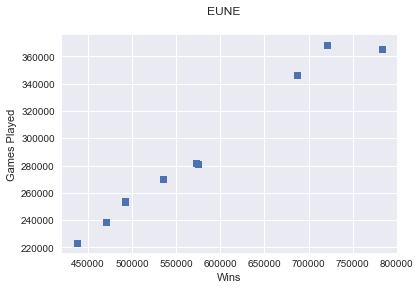

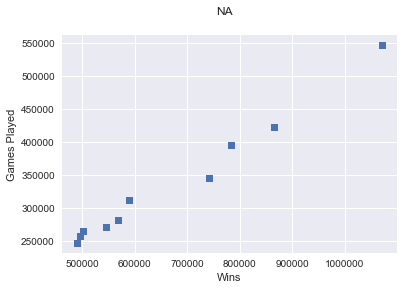

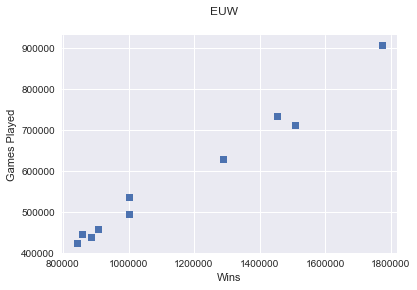

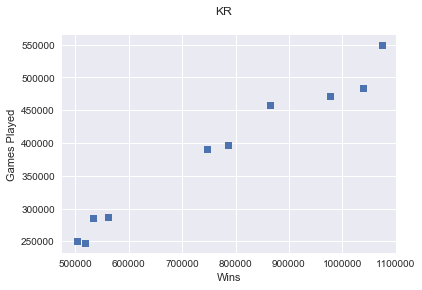

In [26]:
f1 = pyplot.figure(1)
f1.suptitle('EUNE')
pyplot.xlabel('Wins')
pyplot.ylabel('Games Played')
pyplot.plot(most_pop_champ_EUNE.total_games.values, most_pop_champ_EUNE.total_wins.values,'s')
f2 = pyplot.figure(2)
f2.suptitle('NA')
pyplot.xlabel('Wins')
pyplot.ylabel('Games Played')
pyplot.plot(most_pop_champ_NA.total_games.values, most_pop_champ_NA.total_wins.values,'s')
f3 = pyplot.figure(3)
f3.suptitle('EUW')
pyplot.xlabel('Wins')
pyplot.ylabel('Games Played')
pyplot.plot(most_pop_champ_EUW.total_games.values, most_pop_champ_EUW.total_wins.values,'s')
f4 = pyplot.figure(4)
f4.suptitle('KR')
pyplot.xlabel('Wins')
pyplot.ylabel('Games Played')
pyplot.plot(most_pop_champ_KR.total_games.values, most_pop_champ_KR.total_wins.values,'s')

Calculating the correlation coefficient between the games played and the number of wins we get

In [27]:
corr1 = most_pop_champ_EUNE.corr()
print('EUNE:', corr1['total_games'].total_wins)
corr2 = most_pop_champ_NA.corr()
print('NA:', corr2['total_games'].total_wins)
corr3 = most_pop_champ_EUW.corr()
print('EUW:', corr3['total_games'].total_wins)
corr4 = most_pop_champ_KR.corr()
print('KR:', corr4['total_games'].total_wins)

EUNE: 0.987551976167
NA: 0.991853915549
EUW: 0.991427374071
KR: 0.986515671018


This shows a high correlation between the number of games played and the number of wins in the popular champions

We will now attempt to use a linear regression model derived from one of the regions to see whether it is capable of accurately predicting the wins in the other regions

In [28]:
wins1 = most_pop_champ_EUNE.total_wins 
played1 = most_pop_champ_EUNE.total_games
outcome_1, predictors_1 = patsy.dmatrices('wins1 ~ played1', data=most_pop_champ_EUNE)
mod_1 = sm.OLS(outcome_1, predictors_1)    # Describe model
res_1 = mod_1.fit()   # Fit model
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  wins1   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     315.3
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           1.03e-07
Time:                        22:51:12   Log-Likelihood:                -103.93
No. Observations:                  10   AIC:                             211.9
Df Residuals:                       8   BIC:                             212.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.935e+04   1.48e+04      1.977      0.0

C:\Users\Jun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


The above model fits the data to the EUNE data and creates a linear regression model that we will now apply to the NA data and see how well it predicts the number of wins. The values for the percent error between the predicted number of wins and the actual number of wins is shown below.

In [29]:
#NA
wins2 = most_pop_champ_NA.total_wins 
played2 = most_pop_champ_NA.total_games
outcome_2, predictors_2 = patsy.dmatrices('wins2 ~ played2', data=most_pop_champ_NA)
predictions_NA = res_1.predict(predictors_2)
diff_2 = wins2-predictions_NA
percent_err_2 = (diff_2/wins2)*100
print('Percent Error Values for NA:\n', percent_err_2.abs())

#EUW
wins3 = most_pop_champ_EUW.total_wins 
played3 = most_pop_champ_EUW.total_games
outcome_3, predictors_3 = patsy.dmatrices('wins3 ~ played3', data=most_pop_champ_EUW)
predictions_EUW = res_1.predict(predictors_3)
diff_3 = wins3-predictions_EUW
percent_err_3 = (diff_3/wins3)*100
print('Percent Error Values for EUW:\n', percent_err_3.abs())

#KR
wins4 = most_pop_champ_KR.total_wins 
played4 = most_pop_champ_KR.total_games
outcome_4, predictors_4 = patsy.dmatrices('wins4 ~ played4', data=most_pop_champ_KR)
predictions_KR = res_1.predict(predictors_4)
diff_4 = wins4-predictions_KR
percent_err_4 = (diff_4/wins4)*100
print('Percent Error Values for KR:\n', percent_err_4.abs())


Percent Error Values for NA:
 0    6.682258
1    1.216206
2    3.461535
3    4.779034
4    5.626675
5    0.796044
6    1.491503
7    3.707933
8    1.772212
9    1.264568
Name: total_wins, dtype: float64
Percent Error Values for EUW:
 0     8.899246
1     0.577388
2     7.196652
3     3.326962
4    10.729569
5     3.334098
6     5.027295
7     2.827390
8     7.223025
9     3.851712
Name: total_wins, dtype: float64
Percent Error Values for KR:
 0    6.839388
1    2.427157
2    0.841633
3    8.575728
4    3.635307
5    6.665408
6    1.982036
7    5.648912
8    5.716673
9    1.897585
Name: total_wins, dtype: float64


As we can see from the percent error values, none of them exceed 11% error. This gives us evidence that it is possible to use interregional information based on the number of games played (with any of the popular champions) in order to predict the number of wins that were obtained with that champion with a relatively small margin of error.

# Overview 

Given the increasing number of players and interests in E-Sports, it is crucial to provide, extract, transform, and analyze data that the audience can understand. With data, we can better understand how to win in competitive games, what to balance (what rules or implementations need to be placed), as well as better entertain the audience with educated observations. 

In this project, we used Python and its packages to:
1) Extract data from large data sets and place into dataframes to work with
2) Visualize data from these dataframes, using statistical expressions learned in class
3) And analyze our findings (text, relational databases, and visualizations).

We were able to find out relatively quickly from our data that South Korea as a region has performed the best in the past, with SKT being the team leader. Using SKT as a standard, one of the first steps we took was  to measure gold differences, champion picks, and item picks. These in-game details allowed us to show how other teams and regions compare with SKT and Korea, as well as the relatively similar choices (for items and champions) for the runner uppers. However, we noticed that SKT had large gold differences, but a low variance in time intervals. 

We took a look at the gold difference from each team, an indicator of an advantage that team holds over the other team. According to “Gold Difference @15” plot, we can find it strange because Korean teams (LCK) have relatively low gold difference spikes. But the gold difference in fact should get decreasing for high ranked team because these teams stay longer at each tournament and fight against a lot harder opponents. It’s easy to make the difference bigger when higher ranked teams vs lower ranked teams.

Later, we considered Gold Shift Events (GSE) might be the case that leads teams to win. GSE refers to individual events where gold is earned rapidly. GSE usually happens when killing opponent’s characters, destroying buildings or territory are claimed. Extracting the data and plotting, we were finally able to find out now LCK teams here are all taking 1st to 3rd place according to the mean GSE value plot.

We also checked GSE Won %, which tells about how often those events occur in a team's favor. And of course here also 2 of LCK are taking 1st and 2nd place as well. 

Despite GSE mean value, we found that internet speed is one of the crucial factor when it comes to increasing winning rate, as the faster the internet connection, the more connected players become to the game. By extracting data regarding network ping and latency, as expected, South Korea has the fastest Avg. Mbps (a measure of data transfer speed. A megabit is equal to one million bits) 

More over, League of Legend has champions that have unique skills and power. According to our Champions choices and performances data, we were able to find out that popularity of champion doesn’t necessarily mean that they have good win-rate. But rather according to our Attempting to Predict Number of Wins Based on Number of Games Played with Popular Champions, we have high correlation between the number of games with the champion played and wining rate. Lastly, through the linear regression model derived from one of the regions, we were able to know with less than 11% error, it’s possible to use this correlation of the character interregionally, thanks to relatively small margins of error.

In LoL and any ESports game, the game is always evolving and changing in terms of different aspects to the game, such as items, external factors, funding, and balance changes. What might have been a major factor at one time period of LoL could be replaced by another factor in the future, or could have past changes we did not fully account for. There is a need to continue to gather data and provide analyses, so as to increase the prestige and level of E-Sports as part of the entertainment industry.  